In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import matplotlib.dates as mdates

from tueplots import bundles

from bocpd import bocpd
from hazard import ConstantHazard
from models import DSMGammaSampling
from plot import plot_posterior

In [2]:
DATA_PATH = os.path.join(SCRIPT_DIR,'data/bond')
RESULT_PATH = os.path.join(SCRIPT_DIR,'notebooks/results/bond')
FILE_PATH = os.path.join(DATA_PATH,'United Kingdom 10-Year Bond Yield Historical Data.csv')

In [3]:
df = pd.read_csv(FILE_PATH)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
data = df['Price'].values
dates = df['Date'].values

In [4]:
T = len(data)
data = data.reshape((T,1))

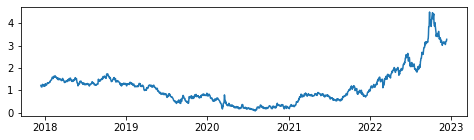

In [5]:
plt.subplots(figsize=(8,2))
plt.plot(dates,data)

In [6]:
def m(x):
    return np.asarray([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.asarray([[-x/((1+x**2)**(3/2))]])

def grad_t(x):
    return np.asarray([[1/x,-1]],dtype='float')

def grad_b(x):
    return np.asarray([[0]])

def hess_t(x):
    return np.asarray([[[-1/(x**2),0]]],dtype='float')

beta = 0.15
k_mu0 = 0
theta_mu0 = 1

k_Sigma0 = 10
theta_Sigma0 = 1


mu0 = np.asarray([[k_mu0], [theta_mu0]])

Sigma0 = np.eye(2)
Sigma0[0,0] = k_Sigma0
Sigma0[1,1] = theta_Sigma0

model = DSMGammaSampling(data, m ,grad_m, grad_t, hess_t, grad_b, beta, mu0, Sigma0, b = 20)

In [7]:
hazard = ConstantHazard(100)

In [8]:
%%time
R_DSM_sampling  = bocpd(data, hazard, model, K=50, verbose=True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
Processing observation #500
Processing observation #600
Processing observation #700
Processing observation #800
Processing observation #900
Processing observation #1000
Processing observation #1100
Processing observation #1200
Processing observation #1300
Processing observation #1400
Processing observation #1500
CPU times: user 3min 59s, sys: 476 ms, total: 4min
Wall time: 4min 5s


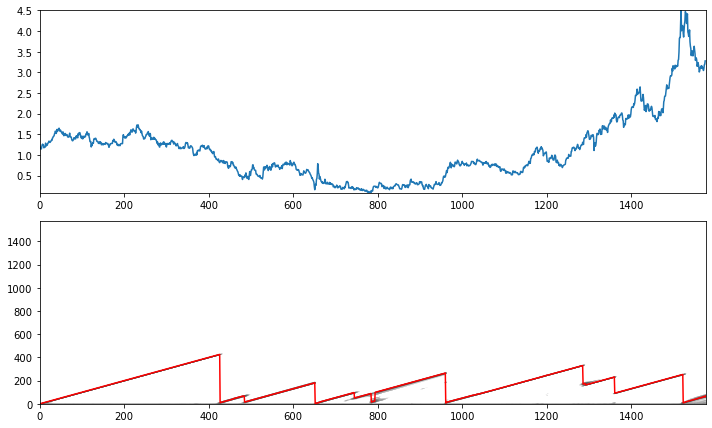

In [9]:
plot_posterior(T, data, R_DSM_sampling)

In [10]:
def find_CPs(R, lag = 20):
    n = len(R)
    CPs = [0]
    last_CP = 0
    for i in range(n):
        candidate = i-np.argmax(R[i,:])
        if candidate > last_CP+lag:
            if (candidate not in CPs):
                CPs.append(candidate)
                last_CP = np.max(CPs)
        if candidate < last_CP:
            try:
                CPs.remove(last_CP)
                last_CP = np.max(CPs)
            except:
                pass
    return CPs

In [11]:
cps = find_CPs(R_DSM_sampling)

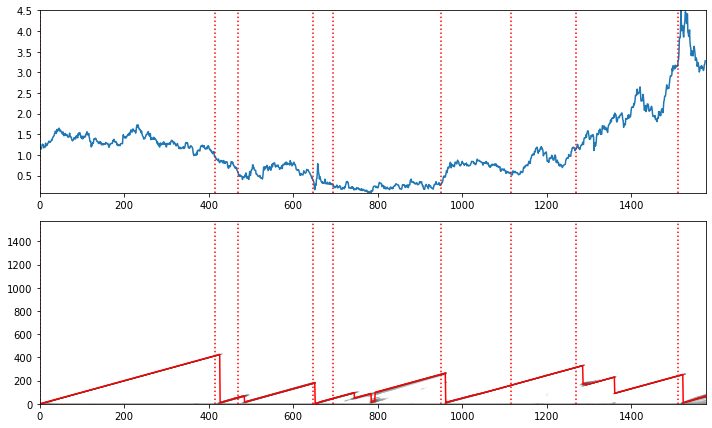

In [12]:
plot_posterior(T, data, R_DSM_sampling, cps)

/tmp/ipykernel_32737/4240711730.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


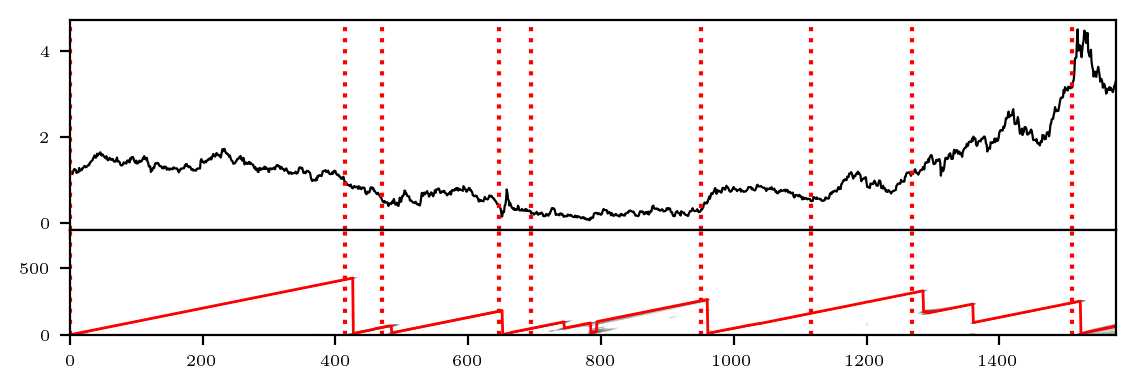

In [13]:
FILE_NAME = 'Bond_full.pdf'
R = R_DSM_sampling
cp = cps
with plt.rc_context(bundles.icml2022(column='full', ncols=2)):

    fig, ax = plt.subplots(2, 1, sharex = True , gridspec_kw={'height_ratios': [2,1]}, dpi = 200)
    ax[0].set_xlim([0,T])
    ax[0].plot(data[:,0],c='black',lw=0.8)

    ax[1].set_xlim([0,T])
    ax[1].set_ylim([0,T/2])
    ax[1].imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[1].plot(np.argmax(R,axis=1), c='r', alpha=1, lw=1)

    for cp in cps:
        ax[0].axvline(cp, c='red', ls='dotted', lw=1.5)
        ax[1].axvline(cp, c='red', ls='dotted', lw=1.5)
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")

/tmp/ipykernel_32737/1785482886.py:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0)


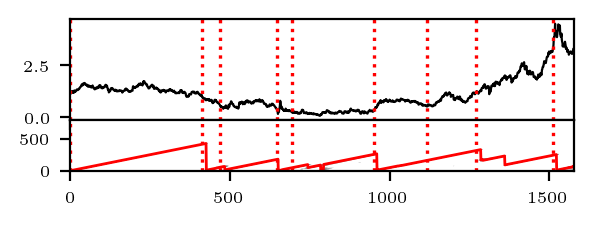

In [14]:
FILE_NAME = 'Bond_col.pdf'
R = R_DSM_sampling
cp = cps
with plt.rc_context(bundles.icml2022(ncols=2)):

    fig, ax = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [2,1]}, dpi = 200)
    ax[0].set_xlim([0,T])
    ax[0].plot(data[:,0],c='black',lw=0.8)

    ax[1].set_xlim([0,T])
    ax[1].set_ylim([0,T/2])
    ax[1].imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
                   norm=LogNorm(vmin=0.0001, vmax=1), extent=[0,T,0,T])
    ax[1].plot(np.argmax(R,axis=1), c='r', alpha=1, lw=1)

    for cp in cps:
        ax[0].axvline(cp, c='red', ls='dotted', lw=1.2)
        ax[1].axvline(cp, c='red', ls='dotted', lw=1.2)
    fig.subplots_adjust(hspace=0)
    fig.savefig(os.path.join(RESULT_PATH, FILE_NAME), format="pdf", bbox_inches= "tight")